Iteration 1: Best path cost so far = 2.00
Iteration 2: Best path cost so far = 2.00
Iteration 3: Best path cost so far = 2.00
Iteration 4: Best path cost so far = 2.00
Iteration 5: Best path cost so far = 2.00
Iteration 6: Best path cost so far = 2.00
Iteration 7: Best path cost so far = 2.00
Iteration 8: Best path cost so far = 2.00
Iteration 9: Best path cost so far = 2.00
Iteration 10: Best path cost so far = 2.00
Iteration 11: Best path cost so far = 2.00
Iteration 12: Best path cost so far = 2.00
Iteration 13: Best path cost so far = 2.00
Iteration 14: Best path cost so far = 2.00
Iteration 15: Best path cost so far = 2.00
Iteration 16: Best path cost so far = 2.00
Iteration 17: Best path cost so far = 2.00
Iteration 18: Best path cost so far = 2.00
Iteration 19: Best path cost so far = 2.00
Iteration 20: Best path cost so far = 2.00
Iteration 21: Best path cost so far = 2.00
Iteration 22: Best path cost so far = 2.00
Iteration 23: Best path cost so far = 2.00
Iteration 24: Best p

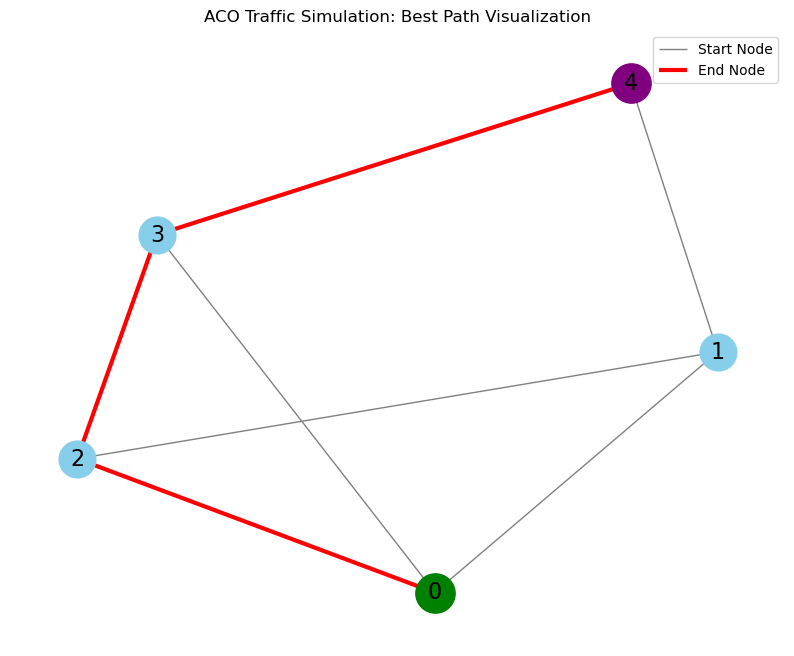

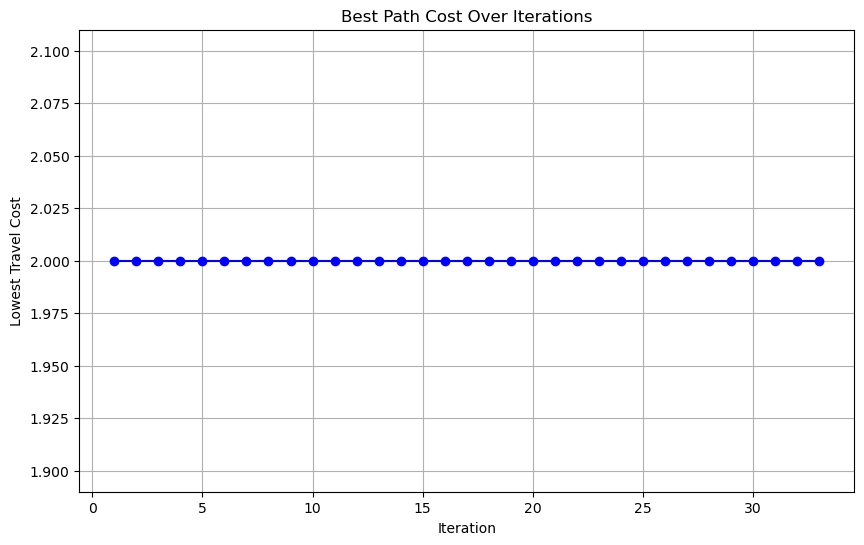

In [24]:
import numpy as np
import random
import matplotlib.pyplot as plt
import networkx as nx

# A simplified representation of a city's road network
# Adjacency matrix where a value indicates the distance between intersections.
# 0 indicates no direct connection.
# Nodes: 0, 1, 2, 3, 4
DISTANCES = np.array([
    [0, 2, 2, 1, 0],
    [2, 0, 1, 0, 3],
    [0, 5, 4, 4, 0],
    [1, 0, 0, 0, 2],
    [0, 0, 0, 2, 0]
])

# Define the initial traffic cost for each road segment (inverse of speed).
# Lower values mean less congestion.
INITIAL_TRAFFIC_COST = np.array([
    [0, 0.2, 0, 0.1, 0],
    [0.2, 0, 0, 0, 0.3],
    [0, 0.5, 0, 0.4, 0],
    [0.1, 0, 0.4, 0, 0.2],
    [0, 0.3, 0, 0.1, 0]
])

class TrafficACO:
    def __init__(self, distances, traffic_costs, n_ants, n_iterations, decay, alpha=1, beta=2):
        self.distances = distances
        self.traffic_costs = traffic_costs
        self.n_ants = n_ants
        self.n_iterations = n_iterations
        self.decay = decay
        self.alpha = alpha
        self.beta = beta
        self.n_intersections = len(distances)
        self.pheromone = np.ones(self.distances.shape) / self.n_intersections
        self.best_path = None
        self.best_path_cost = float('inf')
        self.best_cost_history = [] # To store the best cost per iteration for plotting

    def run(self, start_node, end_node):
        for i in range(self.n_iterations):
            all_paths = self.generate_paths(start_node, end_node)
            self.update_pheromone(all_paths)

            current_best_cost = float('inf')
            current_best_path = None
            for path in all_paths:
                path_cost = self.calculate_path_cost(path)
                if path_cost < current_best_cost:
                    current_best_cost = path_cost
                    current_best_path = path
            
            if current_best_cost < self.best_path_cost:
                self.best_path_cost = current_best_cost
                self.best_path = current_best_path

            self.best_cost_history.append(self.best_path_cost)
            print(f"Iteration {i+1}: Best path cost so far = {self.best_path_cost:.2f}")

        return self.best_path, self.best_path_cost

    def generate_paths(self, start_node, end_node):
        all_paths = []
        for _ in range(self.n_ants):
            path = self.construct_path(start_node, end_node)
            all_paths.append(path)
        return all_paths

    def construct_path(self, start_node, end_node):
        path = [start_node]
        current_node = start_node
        visited = {start_node}

        while current_node != end_node:
            next_node = self.choose_next_node(current_node, visited)
            if next_node is None:
                return self.construct_path(start_node, end_node)
            path.append(next_node[0])
            visited.add(next_node[0])
            current_node = next_node[0]
            
        return path

    def choose_next_node(self, current_node, visited):
        eta = 1.0 / (self.traffic_costs + 1e-10)
        pheromone_weights = self.pheromone[current_node] ** self.alpha
        heuristic_weights = eta[current_node] ** self.beta
        desirability = pheromone_weights * heuristic_weights
        
        # Avoid already visited nodes and disconnected edges
        desirability[list(visited)] = 0
        desirability[self.distances[current_node] == 0] = 0

        total_desirability = np.sum(desirability)
        if total_desirability == 0:
            return None
            
        probabilities = desirability / total_desirability
        next_node = random.choices(range(self.n_intersections), weights=probabilities, k=1)
        return next_node

    def update_pheromone(self, all_paths):
        self.pheromone *= (1 - self.decay)
        for path in all_paths:
            path_cost = self.calculate_path_cost(path)
            if path_cost > 0:
                pheromone_deposit = 1.0 / path_cost
                for i in range(len(path) - 1):
                    start, end = path[i], path[i+1]
                    self.pheromone[start, end] += pheromone_deposit
                    self.pheromone[end, start] += pheromone_deposit

    def calculate_path_cost(self, path):
        cost = 0
        for i in range(len(path) - 1):
            start, end = path[i], path[i+1]
            cost += self.distances[start, end] * self.traffic_costs[start, end]
        return cost

# --- Visualization functions ---
def create_and_draw_graph(distances, best_path, start_node, end_node):
    """
    Creates a NetworkX graph and visualizes it.
    The best path is highlighted.
    """
    G = nx.Graph()
    for i in range(len(distances)):
        for j in range(i + 1, len(distances)):
            if distances[i, j] > 0:
                G.add_edge(i, j, weight=distances[i, j])

    pos = nx.spring_layout(G, seed=42)  # For consistent layout
    plt.figure(figsize=(10, 8))
    
    # Draw all edges in grey
    all_edges = nx.draw_networkx_edges(G, pos, edge_color='gray', width=1)
    
    # Highlight the best path edges in red with a thicker line
    if best_path:
        path_edges = [(best_path[i], best_path[i+1]) for i in range(len(best_path) - 1)]
        nx.draw_networkx_edges(G, pos, edgelist=path_edges, edge_color='red', width=3)
    
    # Draw nodes
    nx.draw_networkx_nodes(G, pos, node_color='skyblue', node_size=700)
    
    # Draw node labels
    nx.draw_networkx_labels(G, pos, font_size=16, font_color='black')
    
    # Highlight start and end nodes
    nx.draw_networkx_nodes(G, pos, nodelist=[start_node], node_color='green', node_size=800, label="Start")
    nx.draw_networkx_nodes(G, pos, nodelist=[end_node], node_color='purple', node_size=800, label="End")
    
    plt.title("ACO Traffic Simulation: Best Path Visualization")
    plt.legend(['Start Node', 'End Node'])
    plt.axis('off')
    plt.show()

def plot_cost_over_time(cost_history):
    """
    Plots the best path cost over the course of the iterations.
    """
    plt.figure(figsize=(10, 6))
    plt.plot(range(1, len(cost_history) + 1), cost_history, marker='o', linestyle='-', color='b')
    plt.title("Best Path Cost Over Iterations")
    plt.xlabel("Iteration")
    plt.ylabel("Lowest Travel Cost")
    plt.grid(True)
    plt.show()

# --- Simulation Execution with Visualization ---
if __name__ == "__main__":
    start_intersection = 0
    end_intersection = 4

    aco = TrafficACO(
        distances=DISTANCES,
        traffic_costs=INITIAL_TRAFFIC_COST,
        n_ants=15,
        n_iterations=33,
        decay=0.5,
        alpha=1,
        beta=2
    )
    
    best_route, lowest_cost = aco.run(start_node=start_intersection, end_node=end_intersection)
    
    print("\n--- Results ---")
    print(f"Optimal path: {best_route}")
    print(f"Lowest travel cost: {lowest_cost:.2f}")

    # --- Plotting the results ---
    create_and_draw_graph(DISTANCES, best_route, start_intersection, end_intersection)
    plot_cost_over_time(aco.best_cost_history)


Cities: [(60, 200), (180, 200), (80, 180), (140, 180), (20, 160), (100, 160), (200, 160), (120, 140), (40, 120), (100, 120), (180, 100), (60, 80), (120, 80), (180, 60), (20, 40), (100, 40), (200, 40), (40, 20), (120, 20), (180, 20)]

Best path found: [11, 14, 17, 15, 18, 19, 16, 13, 10, 6, 1, 3, 7, 5, 2, 0, 4, 8, 9, 12]
Best distance found: 881.224887878795


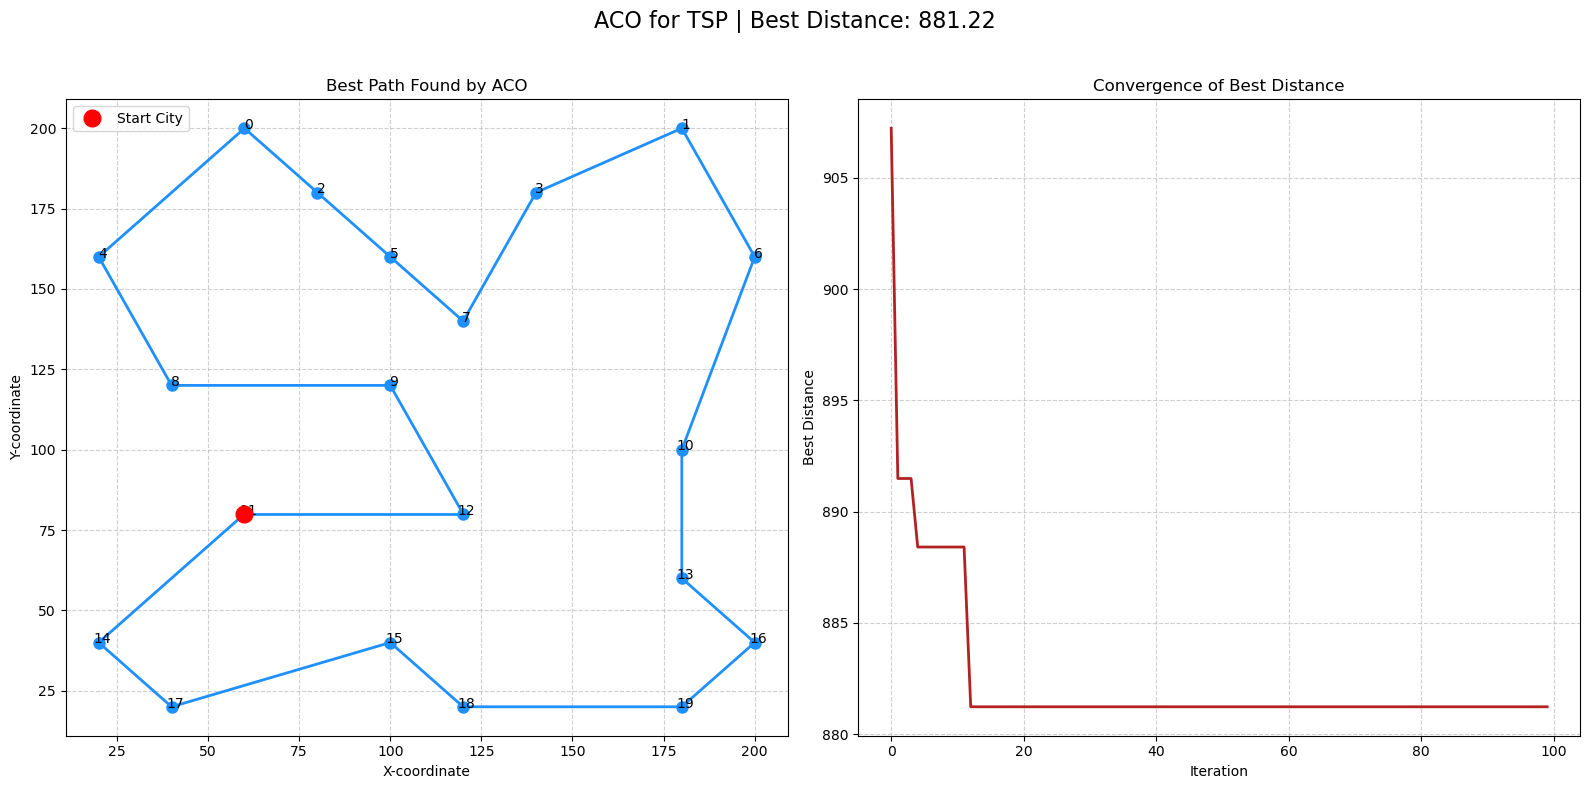

In [1]:
import numpy as np
import random
import matplotlib.pyplot as plt

# =====================================================================================
# --- TSP and ACO Classes ---
# =====================================================================================

class TSP:
    """
    A class to represent the Traveling Salesman Problem (TSP).
    It manages the city coordinates and the pre-computed distance matrix.
    """
    def __init__(self, cities):
        """
        Initializes the TSP problem.
        :param cities: A list of (x, y) tuples representing city coordinates.
        """
        self.cities = cities
        self.num_cities = len(cities)
        self.distance_matrix = self._create_distance_matrix()

    def _create_distance_matrix(self):
        """
        Calculates the Euclidean distance matrix between all pairs of cities.
        :return: A 2D numpy array representing the distances.
        """
        matrix = np.zeros((self.num_cities, self.num_cities))
        for i in range(self.num_cities):
            for j in range(self.num_cities):
                if i != j:
                    matrix[i][j] = self._euclidean_distance(self.cities[i], self.cities[j])
        return matrix

    def _euclidean_distance(self, city1, city2):
        """
        Calculates the Euclidean distance between two cities.
        :param city1: Tuple of (x, y) coordinates for the first city.
        :param city2: Tuple of (x, y) coordinates for the second city.
        :return: The distance between the two cities.
        """
        return np.sqrt((city1[0] - city2[0])**2 + (city1[1] - city2[1])**2)

    def total_distance(self, path):
        """
        Calculates the total distance of a given path.
        :param path: A list of city indices representing a tour.
        :return: The total distance of the tour.
        """
        total = 0
        for i in range(len(path) - 1):
            total += self.distance_matrix[path[i]][path[i+1]]
        total += self.distance_matrix[path[-1]][path[0]]  # Return to start city
        return total


class AntColonyOptimization:
    """
    Implements the Ant Colony Optimization (ACO) algorithm to solve the TSP.
    """
    def __init__(self, problem, num_ants, num_iterations, alpha, beta, evaporation_rate, initial_pheromone):
        """
        Initializes the ACO solver with problem details and parameters.
        :param problem: An instance of the TSP class.
        :param num_ants: Number of ants in the colony.
        :param num_iterations: Number of iterations to run the algorithm.
        :param alpha: Pheromone importance factor.
        :param beta: Heuristic (distance) importance factor.
        :param evaporation_rate: Rate at which pheromones evaporate.
        :param initial_pheromone: Initial amount of pheromone on each path.
        """
        self.problem = problem
        self.num_ants = num_ants
        self.num_iterations = num_iterations
        self.alpha = alpha
        self.beta = beta
        self.evaporation_rate = evaporation_rate
        self.pheromone = np.full((problem.num_cities, problem.num_cities), initial_pheromone)
        self.best_path = None
        self.best_distance = float('inf')
        self.best_distance_history = []

    def run(self):
        """
        Runs the ACO algorithm for the specified number of iterations.
        :return: The best path and its distance found.
        """
        for _ in range(self.num_iterations):
            all_paths = self._construct_solutions()
            self._update_pheromone(all_paths)
            self._update_best_path(all_paths)
            self.best_distance_history.append(self.best_distance)

        return self.best_path, self.best_distance

    def _construct_solutions(self):
        """
        Constructs a complete tour for each ant in the colony.
        :return: A list of all paths constructed by the ants.
        """
        all_paths = []
        for _ in range(self.num_ants):
            path = self._ant_walk()
            all_paths.append(path)
        return all_paths

    def _ant_walk(self):
        """
        Simulates a single ant constructing a tour.
        :return: A list of city indices representing the constructed path.
        """
        path = []
        start_city = random.randint(0, self.problem.num_cities - 1)
        path.append(start_city)
        visited = {start_city}

        while len(path) < self.problem.num_cities:
            current_city = path[-1]
            unvisited_cities = [city for city in range(self.problem.num_cities) if city not in visited]
            
            probabilities = self._calculate_probabilities(current_city, unvisited_cities)
            
            # Select the next city based on probabilities
            next_city = random.choices(unvisited_cities, weights=probabilities, k=1)[0]
            
            path.append(next_city)
            visited.add(next_city)
        
        return path

    def _calculate_probabilities(self, current_city, unvisited_cities):
        """
        Calculates the probability of moving to each unvisited city.
        :param current_city: The ant's current city.
        :param unvisited_cities: A list of cities yet to be visited.
        :return: A numpy array of probabilities.
        """
        pheromone_values = np.array([self.pheromone[current_city][city] for city in unvisited_cities])
        
        # Heuristic values are the inverse of distance
        heuristic_values = np.array([
            1.0 / self.problem.distance_matrix[current_city][city] if self.problem.distance_matrix[current_city][city] > 0 else 0
            for city in unvisited_cities
        ])
        
        numerator = (pheromone_values ** self.alpha) * (heuristic_values ** self.beta)
        denominator = np.sum(numerator)
        
        # Handle case where all probabilities are zero
        if denominator == 0:
            return np.ones(len(unvisited_cities)) / len(unvisited_cities)
        
        return numerator / denominator

    def _update_pheromone(self, all_paths):
        """
        Updates the pheromone matrix by evaporating and depositing pheromones.
        :param all_paths: A list of all paths from the current iteration.
        """
        # Evaporation
        self.pheromone *= (1 - self.evaporation_rate)
        
        # Pheromone deposit
        for path in all_paths:
            path_distance = self.problem.total_distance(path)
            pheromone_deposit = 1.0 / path_distance
            for i in range(len(path) - 1):
                self.pheromone[path[i]][path[i+1]] += pheromone_deposit
            self.pheromone[path[-1]][path[0]] += pheromone_deposit

    def _update_best_path(self, all_paths):
        """
        Compares the paths from the current iteration and updates the best path found so far.
        :param all_paths: A list of all paths from the current iteration.
        """
        for path in all_paths:
            distance = self.problem.total_distance(path)
            if distance < self.best_distance:
                self.best_distance = distance
                self.best_path = path

# =====================================================================================
# --- Visualization Function ---
# =====================================================================================

def plot_tsp_solution(cities, best_path, best_distance, distance_history):
    """
    Visualizes the optimal path and the convergence of the algorithm.
    :param cities: A list of (x, y) tuples representing city coordinates.
    :param best_path: A list of city indices representing the best tour found.
    :param best_distance: The total distance of the best path.
    :param distance_history: A list of best distances found at each iteration.
    """
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 8))
    fig.suptitle(f'ACO for TSP | Best Distance: {best_distance:.2f}', fontsize=16)

    # Plot the TSP path
    coords = np.array([cities[i] for i in best_path])
    x, y = coords[:, 0], coords[:, 1]
    
    ax1.plot(x, y, 'o-', markersize=8, color='dodgerblue', linewidth=2)
    ax1.plot([x[-1], x[0]], [y[-1], y[0]], '-', color='dodgerblue', linewidth=2) # Close the loop
    ax1.plot(x[0], y[0], 'ro', markersize=12, label='Start City', zorder=5)
    
    for i, (cx, cy) in enumerate(cities):
        ax1.text(cx + 1, cy + 1, str(i), fontsize=10, ha='center', va='center')
    
    ax1.set_title('Best Path Found by ACO')
    ax1.set_xlabel('X-coordinate')
    ax1.set_ylabel('Y-coordinate')
    ax1.grid(True, linestyle='--', alpha=0.6)
    ax1.legend()

    # Plot the convergence of the best distance
    ax2.plot(distance_history, color='firebrick', linewidth=2)
    ax2.set_title('Convergence of Best Distance')
    ax2.set_xlabel('Iteration')
    ax2.set_ylabel('Best Distance')
    ax2.grid(True, linestyle='--', alpha=0.6)

    plt.tight_layout(rect=[0, 0, 1, 0.96])
    plt.show()

# =====================================================================================
# --- Main Execution Block ---
# =====================================================================================

if __name__ == '__main__':
    # 1. Define the city coordinates
    cities_list = [
        (60, 200), (180, 200), (80, 180), (140, 180), (20, 160),
        (100, 160), (200, 160), (120, 140), (40, 120), (100, 120),
        (180, 100), (60, 80), (120, 80), (180, 60), (20, 40),
        (100, 40), (200, 40), (40, 20), (120, 20), (180, 20)
    ]

    # 2. Create the TSP problem instance
    tsp_problem = TSP(cities_list)

    # 3. Set ACO parameters
    num_ants = 20
    num_iterations = 100
    alpha = 1.0        # Pheromone importance
    beta = 5.0         # Distance importance (heuristic)
    evaporation_rate = 0.5
    initial_pheromone = 1.0 / (tsp_problem.num_cities * tsp_problem.distance_matrix.mean())

    # 4. Initialize and run the ACO algorithm
    aco_solver = AntColonyOptimization(
        problem=tsp_problem,
        num_ants=num_ants,
        num_iterations=num_iterations,
        alpha=alpha,
        beta=beta,
        evaporation_rate=evaporation_rate,
        initial_pheromone=initial_pheromone
    )
    best_path, best_distance = aco_solver.run()

    # 5. Display and visualize the results
    print("Cities:", cities_list)
    print("\nBest path found:", best_path)
    print("Best distance found:", best_distance)
    
    # Plot the solution
    plot_tsp_solution(cities_list, best_path, best_distance, aco_solver.best_distance_history)

